# Example Tree

Most dependencies are in `environment.yml`, except for [INDELible](http://abacus.gene.ucl.ac.uk/software/indelible/) which has to be installed manually.

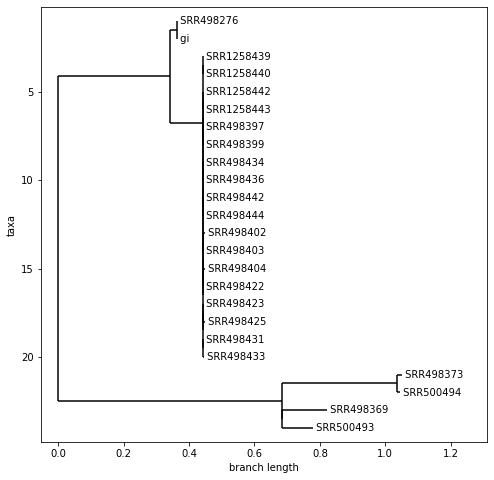

In [1]:
from Bio import Phylo
import matplotlib.pyplot as plt

t = Phylo.read('example/example.tre', 'newick')
plt.rcParams['figure.figsize'] = (8,8)
Phylo.draw(t)

In [2]:
!cat example.config

#REQUIRED PARAMETERS
treefile_path = example/example.tre #Must be newick or Nexus format, and include branch lengths
number_of_variable_sites = 20
base_genome_name = gi #Should be the label of a tip in your tree
base_genome_path = example/mini_ref.fasta
output_dir = example_out


#parameters of evolutionary model (comma seperated), in order ac, ag, at, cg, ct, gc (gc = 1)
rate_matrix = 1,1,1,1,1,1

#parameters for read simulation
coverage = 50 #either an integer or a file name of a comma delimited file with tip names and coverage

#OPTIONAL PARAMETERS
#prefix = sim_ #optional prefix prepended to sequence names, default is using orginal sequence names

#Optional evolutionary model parameters
gamma_shape = 5 #dafault is no rate variation across sites

#parameters for clustering of variable site locations (OPTIONAL)
mutation_clustering = ON
percent_clustered = 0.25 #The percentage of variable sites whose distance to another site is drawn from the clustering distribution
exponential_mean =

In [3]:
!python treetoreads.py example.config

Random seed is 7130023642557482858
Running TreetoReads using configuration file example.config
Arguments read
Number of variable sites is 20
clustering proportion is 0.25
exponential_mean is 2
output directory is example_out
Base frequencies detected from anchor genome A:0.21746031746031746 C:0.2802308802308802 G:0.24877344877344879 T:0.25353535353535356
genome has 1 contigs
Genome has 6930 bases
Tree read
Variable sites generated using seq-gen
writing genome for SRR498276
writing genome for gi
writing genome for SRR1258439
writing genome for SRR1258440
writing genome for SRR1258442
writing genome for SRR1258443
writing genome for SRR498397
writing genome for SRR498399
writing genome for SRR498434
writing genome for SRR498436
writing genome for SRR498442
writing genome for SRR498444
writing genome for SRR498402
writing genome for SRR498403
writing genome for SRR498404
writing genome for SRR498422
writing genome for SRR498423
writing genome for SRR498425
writing genome for SRR498431
wri

In [4]:
!ls example_out

analysis_configuration.cfg  fastq	    seqgen_log	  simtree.tre
art_log			    mutsites.txt    seqs_sim.txt  var_site_matrix
fasta_files		    scaledtree.tre  sim.vcf


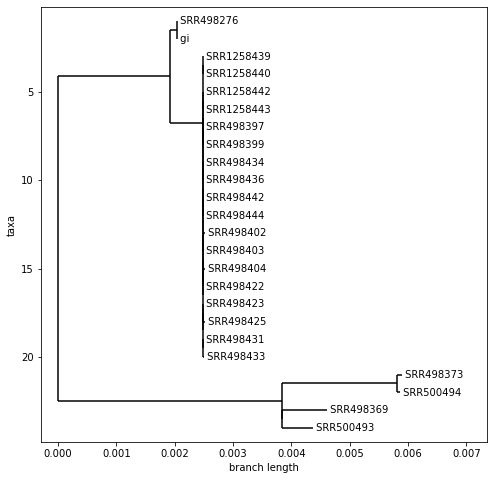

In [5]:
t = Phylo.read('example_out/simtree.tre', 'newick')
plt.rcParams['figure.figsize'] = (8,8)
Phylo.draw(t)

In [6]:
!ls example_out/fastq

SRR1258439  SRR498276  SRR498399  SRR498422  SRR498433	SRR498444
SRR1258440  SRR498369  SRR498402  SRR498423  SRR498434	SRR500493
SRR1258442  SRR498373  SRR498403  SRR498425  SRR498436	SRR500494
SRR1258443  SRR498397  SRR498404  SRR498431  SRR498442	gi


# Build alignment

In [7]:
!conda run --name snippy snippy --version 2>/dev/null

snippy 4.6.0



In [8]:
import os
import glob

reference_file_abs = os.path.abspath('example/mini_ref.fasta')
snippy_out = os.path.abspath('example_out')

with open(f'example_out/snippy.fofn', 'w') as snippy_fofn:
    directory = 'example_out/fastq'
    for sample in os.listdir(directory):
        
        # Skip since this is the reference genome
        if sample == 'gi':
            continue
        
        files = glob.glob(f'{directory}/{sample}/*.fq.gz')
        files = [os.path.abspath(f) for f in files]
        values = [sample]
        values.extend(files)
        snippy_fofn.write('\t'.join(values)+'\n')

In [9]:
!head -n 1 example_out/snippy.fofn

SRR498423	/home/apetkau/workspace/TreeToReads/example_out/fastq/SRR498423/SRR498423_2.fq.gz	/home/apetkau/workspace/TreeToReads/example_out/fastq/SRR498423/SRR498423_1.fq.gz


In [10]:
!conda run --name snippy snippy-multi example_out/snippy.fofn --ref {reference_file_abs} --cpus 2 > {snippy_out}/snippy-commands.sh

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = "en.UTF-8",
	LC_ALL = (unset),
	LC_CTYPE = "C.UTF-8",
	LANG = "en.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
Reading: example_out/snippy.fofn
Generating output commands for 23 isolates
Done.



In [11]:
!head -n 2 {snippy_out}/snippy-commands.sh

snippy --outdir 'SRR498423' --R1 '/home/apetkau/workspace/TreeToReads/example_out/fastq/SRR498423/SRR498423_2.fq.gz' --R2 '/home/apetkau/workspace/TreeToReads/example_out/fastq/SRR498423/SRR498423_1.fq.gz' --ref /home/apetkau/workspace/TreeToReads/example/mini_ref.fasta --cpus 2
snippy --outdir 'SRR500494' --R1 '/home/apetkau/workspace/TreeToReads/example_out/fastq/SRR500494/SRR500494_2.fq.gz' --R2 '/home/apetkau/workspace/TreeToReads/example_out/fastq/SRR500494/SRR500494_1.fq.gz' --ref /home/apetkau/workspace/TreeToReads/example/mini_ref.fasta --cpus 2


In [12]:
!(pushd {snippy_out} && conda run --name snippy bash {snippy_out}/snippy-commands.sh && popd) > {snippy_out}/snippy.log 2>&1

In [13]:
!tail {snippy_out}/snippy.log

Opening: core.tab
Opening: core.vcf
Processing contig: ref
Generating core.full.aln
Creating TSV file: core.txt
Running: snp-sites -c -o core.aln core.full.aln
The Snippy manual is at http://github.com/tseemann/snippy/blob/master/README.md
Done.

~/workspace/TreeToReads


In [14]:
!column -s$'\t' -t {snippy_out}/core.txt

ID          LENGTH  ALIGNED  UNALIGNED  VARIANT  HET  MASKED  LOWCOV
SRR1258439  6930    6713     35         0        0    0       182
SRR1258440  6930    6713     35         0        0    0       182
SRR1258442  6930    6713     35         0        0    0       182
SRR1258443  6930    6713     35         0        0    0       182
SRR498276   6930    6766     21         0        0    0       143
SRR498369   6930    6759     6          12       0    0       165
SRR498373   6930    6789     17         17       3    0       121
SRR498397   6930    6713     35         0        0    0       182
SRR498399   6930    6713     35         0        0    0       182
SRR498402   6930    6762     6          0        0    0       162
SRR498403   6930    6762     6          0        0    0       162
SRR498404   6930    6762     6          0        0    0       162
SRR498422   6930    6754     10         0        0    0       166
SRR498423   6930    6754     10         0        0    0       166
SRR4984

# Build tree

In [15]:
reference_name = 'gi'
!sed -i.bak -e 's/Reference/{reference_name}/' {snippy_out}/core.aln

In [16]:
!iqtree -s {snippy_out}/core.aln -redo

IQ-TREE multicore version 2.0.3 for Linux 64-bit built Dec 20 2020
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor,
Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Host:    PHAC5023362 (AVX512, FMA3, 12 GB RAM)
Command: iqtree -s /home/apetkau/workspace/TreeToReads/example_out/core.aln -redo
Seed:    231630 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Mon Jan 18 13:23:47 2021
Kernel:  AVX+FMA - 1 threads (8 CPU cores detected)

HINT: Use -nt option to specify number of threads because your CPU has 8 cores!
HINT: -nt AUTO will automatically determine the best number of threads to use.

Reading alignment file /home/apetkau/workspace/TreeToReads/example_out/core.aln ... Fasta format detected
Alignment most likely contains DNA/RNA sequences
Alignment has 24 sequences with 20 columns, 16 distinct patterns
16 parsimony-informative, 4 singleton sites, 0 constant sites
            Gap/Ambiguity  Composition  p-value
   1  gi            0.00%    passed    

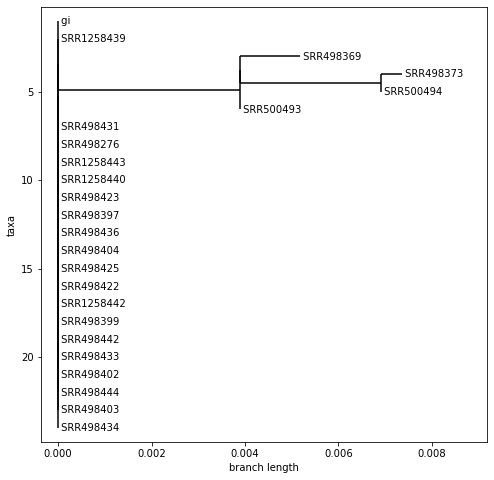

In [17]:
t = Phylo.read(f'{snippy_out}/core.aln.treefile', 'newick')
plt.rcParams['figure.figsize'] = (8,8)
Phylo.draw(t)